In [1]:
%load_ext autoreload
%autoreload 2'
%matplotlib inline

In [2]:
import sys
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [3]:
def merge_and_fill_trajectories(pandas_data_frames, default_value=None):
    # merge all trajectories keeping all time steps
    df = pd.DataFrame().join(pandas_data_frames, how='outer')

    # forward fill to make it a propper step function
    df = df.fillna(method='ffill')
    if default_value is None:
        # backward fill to replace the NaNs for the early times by the
        # performance of a random configuration
        df = df.fillna(method='bfill')
    else:
        df = df.fillna(default_value)
    return df


def get_trajectories(losses, iterations):
    dfs = []
    for i in range(len(losses)):
        loss = losses[i]
        iteration = iterations[i]
        # print('Run %d, Min: %f'%(i, loss))
        df = pd.DataFrame({str(i): loss}, index=iteration)
        dfs.append(df)

    df = merge_and_fill_trajectories(dfs, default_value=None)
    if df.empty:
        pass

    return np.array(df.T), np.array(df.index)

In [4]:
def get_results(predictor, path, epochs, metric='valid_acc', dataset='cifar10', ug=False):
    
    output = []
    time = []
    nan_count = 0
    missing_results_count = 0
    
    algo_path = os.path.join(path, predictor)
    for seed_dir in os.listdir(algo_path):
        result_file = os.path.join(algo_path, seed_dir, 'errors.json')
        result = json.load(open(result_file))
        
        config = result[0]
        val_acc = result[1]['valid_acc'][:epochs]
        surr_time = np.array(result[1]['runtime'])[:epochs]
        if ug:
            runtime = 200*np.array(result[1]['train_time'])[:epochs] + surr_time
        else:
            runtime = np.array(result[1]['train_time'])[:epochs] + surr_time

        val_err = [100 - x for x in val_acc]
        val_incumbent = [min(val_err[:epoch]) for epoch in range(1, len(val_err)+1)]
        runtime = [sum(runtime[:epoch]) for epoch in range(1, len(runtime)+1)]

        if metric == 'valid_acc':
            incumbent = val_incumbent
        elif metric == 'test_acc':
            test_err = [100 - x for x in result[1]['test_acc']]
            inc_idx, best, best_idx = [], np.inf, 0
            for i, err in enumerate(val_err):
                if err < best:
                    best, best_idx = err, i
                inc_idx.append(best_idx)
            incumbent = [test_err[idx] for idx in inc_idx]

        if len(incumbent) == epochs:
            output.append(incumbent)
            time.append(runtime)
        else:
            nan_count += 1

    output = np.array(output)
    time = np.array(time)

    output, time = get_trajectories(output, time)
    
    print(predictor, 'output shape', output.shape, 'nans', nan_count, 'missing files', missing_results_count)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    std_error = np.sqrt(np.var(output, axis=0, ddof=1)/np.asarray(output).shape[0])
    return mean, std, std_error, time



In [5]:
# set up colors and plot markings
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# goes up to 24
c_max = 9
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-']*c_max, *['--']*c_max, *[':']*c_max]
markers = [*['^']*c_max, *['v']*c_max, *['o']*c_max]

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html


pred_label_dict={
    'valloss':'Val. Loss', 'valacc':'Val. Acc.', 'sotl':'SoTL', 'bananas':'BANANAS',
    'mlp':'Feedforward', 'gbdt':'GBDT', 'gcn':'GCN', 'bonas_gcn':'BONAS', 'xgb':'XGB',
    'ngb':'NGB', 'rf':'RF', 'jacov':'Jacob. Cov.', 'dngo':'DNGO', 'bohamiann':'BOHAMIANN', 
    'bayes_lin_reg':'Bayes. Lin. Reg.', 'ff_keras':'FF-Keras', 'gp':'GP', 'sparse_gp':'Sparse GP', 
    'var_sparse_gp':'Var. Sparse GP', 'seminas':'SemiNAS', 'lcsvr':'LcSVR', 'snip':'SNIP', 'sotle':'SoTLE',
    'bonas':'BONAS', 'omni_lofi':'Omni Lofi', 'nao': 'NAO', 'lgb': 'LGB', 'none': 'True'
}

In [8]:
# set up parameters for the experiments
epochs = 300
results_dict = {}

folder = os.path.expanduser('../docs/re_run_0/cifar10/nas_predictors/nasbench201')
predictors=('mlp', 'lgb', 'xgb', 'rf', 'gp', 'none')

for i, predictor in enumerate(predictors):
    mean, std, std_error, runtime = get_results(predictor, folder, epochs=epochs, metric='test_acc', ug=True)
    results_dict[predictor] = {'label':pred_label_dict[predictor], 
                               'key':predictor, 'mean':mean, 'std':std, 
                               'std_error': std_error, 'runtime': runtime}

mlp output shape (3, 900) nans 0 missing files 0
lgb output shape (3, 900) nans 0 missing files 0
xgb output shape (3, 900) nans 0 missing files 0
rf output shape (3, 900) nans 0 missing files 0
gp output shape (3, 900) nans 0 missing files 0
none output shape (3, 900) nans 0 missing files 0


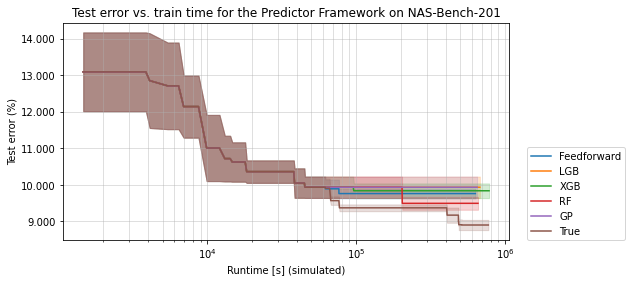

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import FormatStrFormatter

# plot performance vs runtime

# didn't run them long enough to do logspace here. (These experiments took surprisingly long to run)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = 'dotted'

plot_zoomed = False
plot_sem = True

fig, ax = plt.subplots(figsize=[8, 4])
if plot_zoomed:
    sub_axes = plt.axes([.6, .6, .25, .25]) 

for i, key in enumerate(predictors):
    mean = results_dict[key]['mean']
    sem = results_dict[key]['std_error']
    label = results_dict[key]['label']
    x = results_dict[key]['runtime']
    
    ax.plot(x, mean, label=label, color=colors[i], linestyle=fmts[i])
    if plot_sem:
        ax.fill_between(x, mean-1*sem, mean+1*sem,
                        color=colors[i], alpha=0.2)
    
    if plot_zoomed:
        X_detail = x[-10000:]
        Y_detail = mean[-10000:]
        sem_detail = sem[-10000:]
        sub_axes.plot(X_detail, Y_detail, color=colors[i], linestyle=fmts[i])
        sub_axes.fill_between(X_detail, Y_detail-1*sem_detail, Y_detail+1*sem_detail,
                         color=colors[i], alpha=0.2)
        sub_axes.tick_params(labelbottom=False) 
        sub_axes.set_xlim([700000, 900000])
    
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xscale('log')
#ax.set_ylim([7, 11])
#ax.set_xlim([1e4, 1.6e6])

ax.legend(loc=(1.04,0))
ax.set_xlabel('Runtime [s] (simulated)')
ax.set_ylabel('Test error (%)')
ax.grid(True, which="both",ls="-", alpha=.5)
ax.set_title('Test error vs. train time for the Predictor Framework on NAS-Bench-201')
plt.savefig('plot_nb201.pdf', bbox_inches = 'tight', pad_inches = 0.1)
